In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import random
from scipy.optimize import root
from collections import Counter

In [2]:
def shifted_poisson(lam = 1,size = None):
    '''
    Draw samples from a 1+Poisson distribution.

    The Poisson distribution is the limit of the binomial distribution
    for large N.

    Parameters
    ----------
    lam : float or array_like of floats
        Expectation of interval, must be >= 1. A sequence of expectation
        intervals must be broadcastable over the requested size.
        Poisson distribution is extracted with average degree lam-1
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  If size is ``None`` (default),
        a single value is returned if ``lam`` is a scalar. Otherwise,
        ``np.array(lam).size`` samples are drawn.

    Returns
    -------
    out : ndarray or scalar
        Drawn samples from the parameterized Poisson distribution.
    '''

    
    return np.random.poisson(lam = lam-1,size = size)+1
np.random.shifted_poisson = shifted_poisson

- degree of individual : number of cluster a person belongs to 
- degree of cluster:  number of people in the cluster

{'lam': 5}


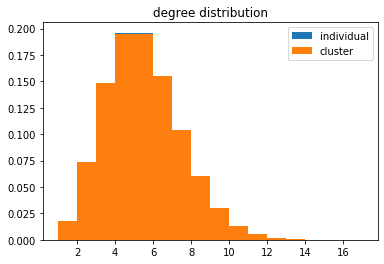

In [51]:
N_a = 100_000# n people
N_b = 100_000 #n clusters
a_mean = 5
b_mean = (a_mean )* N_a / N_b 
aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})

plt.hist(aseq,bins = np.arange(min(aseq),max(aseq)+1),density=True,label = 'individual')
plt.hist(bseq,bins = np.arange(min(bseq),max(bseq)+1),density=True,label = 'cluster')
plt.title('degree distribution')
plt.legend()

In [52]:
sum(aseq)/sum(bseq)

1.0

In [53]:
def bipartite_degree_seq(N_a,N_b,pmf_a,pmf_b,a_params,b_params):
    '''
    generate the degree sequences according to the degree distribution specified.
    Accepted degree distributions are list at np.random.__all__
    Parameters:
    N_a: int
        number of nodes in layer a
    N_b: int
        number of nodes in layer b        
    pmf_a: string
        name of the distribution from which degree sequence is sampled, for nodes a
    pmf_b: string
        name of the distribution from which degree sequence is sampled, for nodes b
    a_params: dict
        parameters of the distribution pmf_a
    b_params: dict
        parameters of the distribution pmf_b
    Returns:
    aseq: np.array
        degree sequence layer a
    bseq: np.array
        degree sequence layer b
    Usage:
    N_a = 10000
    N_b = 1000
    a_mean = 1
    a,b = bipartite_degree_seq(N_a,N_b,'poisson','poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})

    '''
    print(a_params)
    afunc = getattr(np.random,pmf_a)
    aseq =afunc(**a_params,size = N_a) 
    bseq =afunc(**b_params,size = N_b) 
    diff =np.sum(aseq)- np.sum(bseq) 
    if abs(diff/np.sum(aseq))>0.01:
        raise ValueError('It is likely that statistically the sum of the two degree sequence differs')
    while diff != 0:
        n_new_samples = len(aseq) #int(abs(diff) /a_mean)
        new_samples = np.random.poisson(a_mean -1, n_new_samples)+1
        for proposed in new_samples:
            i = np.random.choice(len(aseq))
            k = aseq[i]
            if abs(diff -k+ proposed )<abs(diff):
                aseq[i] = proposed
                diff = diff -k+ proposed
    return aseq,bseq


In [54]:
aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})

np.mean(aseq),np.mean(bseq)

{'lam': 5}


(5.00132, 5.00132)

In [85]:
BG = bipartite.generators.configuration_model(aseq,bseq)
p = 0.7# prob to remove a link, i.e not to trasmit disease
edgs_list = list(BG.edges())
edgs_to_rm = random.sample(edgs_list,k = int(len(edgs_list)*p))
BG.remove_edges_from(edgs_to_rm)
CC= max(nx.algorithms.connected_components(BG),key = len)


In [86]:
CC = np.array(list(CC))
print('fraction of individuals infected',np.count_nonzero(CC<N_a)/N_a,'\nfraction of clusters infected',np.count_nonzero(CC>=N_a)/N_b)



fraction of individuals infected 0.99998 
fraction of clusters infected 0.99998


In [497]:
np.random.poisson?

In [108]:
def f(x,c,d,T):
    return    -x + (np.exp(-((d*p*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c)))*
          (-1 - d + (d*p*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c) + np.exp((d*p*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c)) + 
            d*np.exp((d*p*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c))))/(1 + d)

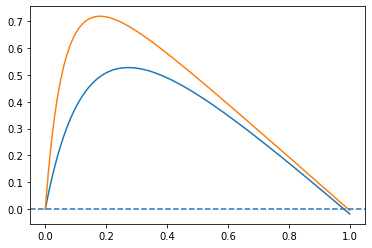

In [64]:
xs = np.linspace(0,1,100)
plt.plot(xs,[f(x,a_mean-1,b_mean-1,1-p) for x in xs])
plt.plot(xs,[f(x,a_mean-1,b_mean-1,p) for x in xs])
plt.axhline(0,ls = '--')

In [114]:
solution = root(f,1,args=(a_mean-1,b_mean-1,1-p))
print(solution)
np.exp(-(a_mean-1)*solution.x)*(-1+np.exp((a_mean-1)*solution.x)+solution.x)

    fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 5
     qtf: array([2.31088115e-09])
       r: array([0.99618172])
  status: 1
 success: True
       x: array([0.97274576])


array([0.99944333])

In [ ]:
solution.x

<BarContainer object of 17 artists>

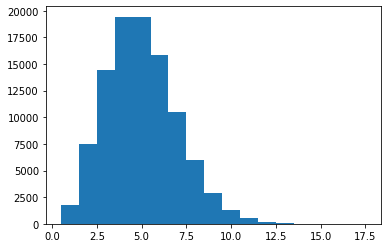

In [83]:
count = Counter(aseq)
plt.bar(count.keys(),count.values(),1)

In [74]:
Counter(aseq).values()

dict_values([19440, 19428, 7510, 1796, 15831, 2897, 10514, 567, 14479, 188, 5993, 1269, 58, 24, 4, 1, 1])

In [89]:
BG_1 = nx.Graph(BG)

<BarContainer object of 17 artists>

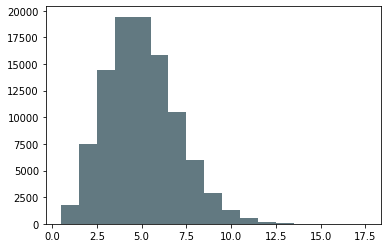

In [107]:
plt.bar(*zip(*Counter(dict(BG_1.degree(range(N_a))).values()).items()),1)
plt.bar(*zip(*Counter(aseq).items()),1,alpha = 0.3)

In [102]:
BG.degree?